In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv("/content/years.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3240 non-null   int64  
 1   x       3240 non-null   float64
 2   y       3240 non-null   float64
 3   date    3240 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 101.4+ KB


In [ ]:
df['date'].unique()

array(['2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
       '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
       '2008-01-01'], dtype=object)

In [ ]:
df.rename(columns = {'date':'year'}, inplace=True)

In [ ]:
df['year'] = pd.to_datetime(df['year'])

In [ ]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [ ]:
df.year.unique()

<DatetimeArray>
['2000-01-01 00:00:00', '2001-01-01 00:00:00', '2002-01-01 00:00:00',
 '2003-01-01 00:00:00', '2004-01-01 00:00:00', '2005-01-01 00:00:00',
 '2006-01-01 00:00:00', '2007-01-01 00:00:00', '2008-01-01 00:00:00']
Length: 9, dtype: datetime64[ns]

In [ ]:
df.head()

,id,x,y,year
0,1,-0.09414,0.43291,2000-01-01
1,2,-0.09415,0.43409,2000-01-01
2,3,-0.09418,0.43527,2000-01-01
3,4,-0.09423,0.43646,2000-01-01
4,5,-0.09430,0.43764,2000-01-01


In [ ]:
df.shape

(3240, 4)

In [ ]:
from prophet import Prophet

In [ ]:
# 1) Load the dataset
# 2) Define the port (origin) coordinates
#    Replace these with your actual port location
x_port, y_port = -0.1619, 0.43291

# 3) Compute polar coordinates for each point
#    r = distance from port, theta = angle of the radial line
radians = np.arctan2(df['y'] - y_port, df['x'] - x_port)
df['theta'] = radians
# ensure theta is consistent per radial id

df['r'] = np.sqrt((df['x'] - x_port)**2 + (df['y'] - y_port)**2)

# 4) Prepare to store predictions
all_preds = []
forecast_years = 5  # number of years to predict

# 5) Loop over each radial ID and forecast radius
for point in df['id'].unique():
    sub = df[df['id'] == point].copy().sort_values('year')
    if len(sub) < 3:
        # too little history to model
        continue

    # Build Prophet-ready frame for radius
    sub_prophet = sub[['year', 'r']].rename(columns={'year': 'ds', 'r': 'y'})
    # sub_prophet = sub_prophet.set_index('ds').asfreq('YS').interpolate()  # fill yearly gaps
    sub_prophet = sub_prophet.reset_index()

    # Choose between 'linear' or 'logistic'. If using logistic, add 'cap'
    m = Prophet(growth='linear', yearly_seasonality=False, changepoint_prior_scale=0.5)
    m.fit(sub_prophet)

    future = m.make_future_dataframe(periods=forecast_years, freq='YS')
    forecast = m.predict(future)

    # Extract forecasted radii
    preds = forecast[['ds', 'yhat']].tail(forecast_years)

    # 6) Reconstruct x,y from r and theta
    theta = sub['theta'].iloc[0]
    for _, row in preds.iterrows():
        r_pred = max(row['yhat'], sub['r'].iloc[-1])  # enforce non-decrease if desired
        x_pred = x_port + r_pred * np.cos(theta)
        y_pred = y_port + r_pred * np.sin(theta)
        all_preds.append({
            'id': point,
            'year': row['ds'].year,
            'x': x_pred,
            'y': y_pred
        })

# 7) Combine historical and predicted for output
hist = df[['id', 'year', 'x', 'y']]
hist['source'] = 'historical'
pred = pd.DataFrame(all_preds)
pred['source'] = 'forecast'

out = pd.concat([hist, pred], ignore_index=True)
out.to_csv('PredictedCoords.csv', index=False)
print('Refined predictions saved to PredictedCoords_refined.csv')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5dkut6ou/cucbnt7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5dkut6ou/l93ihxvy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41043', 'data', 'file=/tmp/tmp5dkut6ou/cucbnt7i.json', 'init=/tmp/tmp5dkut6ou/l93ihxvy.json', 'output', 'file=/tmp/tmp5dkut6ou/prophet_model04xfjxnw/prophet_model-20250717202200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:22:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Refined predictions saved to PredictedCoords_refined.csv


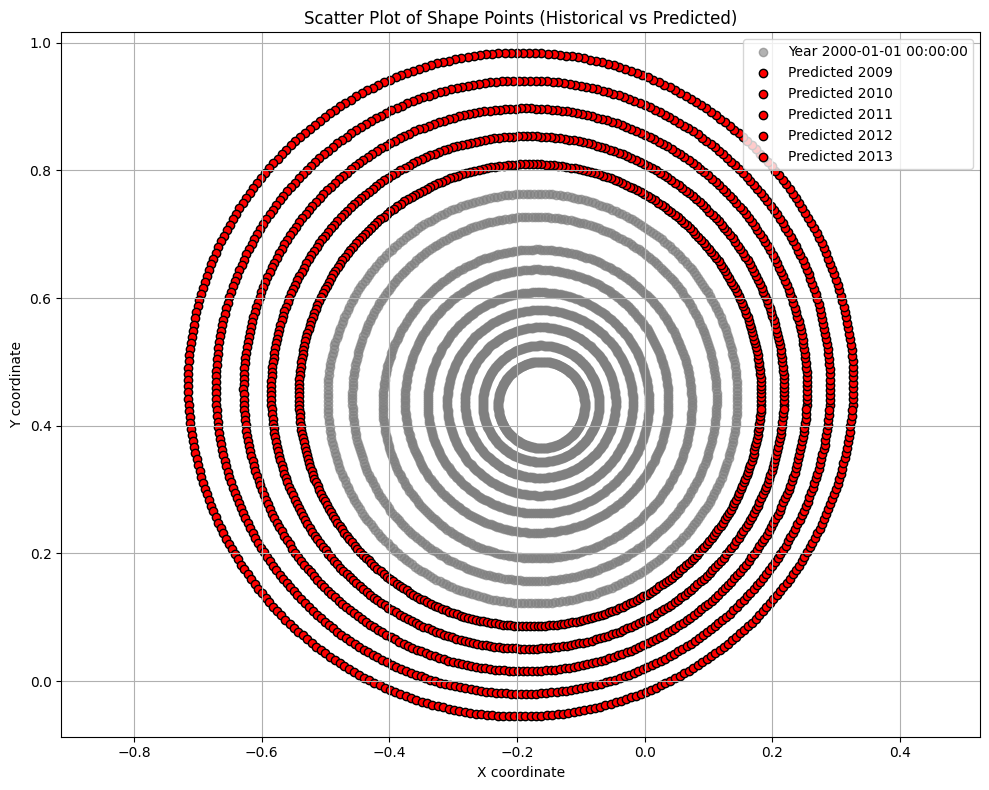

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predicted coordinates

predicted_df = pd.read_csv("/content/PredictedCoords.csv")

# Ensure year is treated as string for consistent plotting
predicted_df['year'] = predicted_df['year'].astype(str)

# Identify predicted years by finding the latest ones
years_sorted = sorted(predicted_df['year'].unique())
predicted_years = years_sorted[-periods:]  # assuming the last 5 years are predicted
historical_years = [yr for yr in years_sorted if yr not in predicted_years]

plt.figure(figsize=(10, 8))

# Plot historical data in gray
for yr in historical_years:
    df_year = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_year['x'], df_year['y'], color='gray', alpha=0.6, label=f"Year {yr}" if yr == historical_years[0] else "")

# Plot predicted data in red
for yr in predicted_years:
    df_pred = predicted_df[predicted_df['year'] == yr]
    plt.scatter(df_pred['x'], df_pred['y'], color='red', edgecolor='black', label=f"Predicted {yr}")

plt.title("Scatter Plot of Shape Points (Historical vs Predicted)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()
